**Table of contents**<a id='toc0_'></a>    
- [OHP Experience](#toc1_)    
  - [I Alpy data](#toc1_1_)    
    - [I.1 Setting](#toc1_1_1_)    
    - [Calibration](#toc1_1_2_)    
      - [First view at the target](#toc1_1_2_1_)    
      - [Calibrate the lamp](#toc1_1_2_2_)    
      - [Flat](#toc1_1_2_3_)    
    - [Correlation](#toc1_1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***

# <a id='toc1_'></a>[OHP Experience](#toc0_)

## <a id='toc1_1_'></a>[I Alpy data](#toc0_)

### <a id='toc1_1_1_'></a>[I.1 Setting](#toc0_)

Import packages

In [11]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import curve_fit

### I.2 Collecting the data

Data are in the folder `proj_3/data_files/`. They are organized into five folders (corresponding to the nights of observation). In each one of them there are other folders with the name of the observed object, that contain, in addition to the data of the corresponding target, also an acquisition for the calibration lamp. Only one flat per night was taken.

All data are reported in the file `proj_3/data_files/objs_per_night.json`. Hence, script extracts and collects these data from the file for first.

In [12]:
def data_extraction(path_file: str) -> dict:
    """Extracting data from a .json file

    :param path_file: path of the data file
    :type path_file: str
    
    :return: data organized into nights of aquisition and objects
    :rtype: dict
    """
    # opening the file
    with open(path_file) as f:
        data_file = f.read()
    # converting in a python dictonary
    data_file = json.loads(data_file)
    return data_file

# names for the selection of the night observation
NIGHTS = [f'0{i}_night' for i in range(1,6)]

# taking path of the current folder
# PWD = os.path.dirname(os.path.realpath(__file__))
PWD = os.getcwd()
# path of the project folder
PROJECT_FOLDER = os.path.split(PWD)[0]
# path of the data folder
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data_files')
# path of calibration folder
CAL_FOLDER = os.path.join(DATA_FOLDER, 'calibration')
# path of results folder
RESULT_FOLDER = os.path.join(PROJECT_FOLDER, 'results')

# file with objects collection
OBJ_FILE = os.path.join(DATA_FOLDER, 'objs_per_night.json')

# extracting data
DATA_ALL = data_extraction(OBJ_FILE)

def collect_fits(night: int, obj: str) -> tuple:
    """Collecting data fits for a chosen night observation
    and object.

    :param night: index of chosen night
    :type night: int
    :param obj: name of the object
    :type obj: str
    
    :return: the list with data fit of that object in that night and section limits for the images
    :rtype: list
    """
    cut = np.loadtxt(os.path.join(DATA_FOLDER, NIGHTS[night], obj, 'cut_indicies.txt'), dtype=int, unpack=False)
    return DATA_ALL[NIGHTS[night]][obj], cut

def data_file_path(night: int, obj: str, data_file: str) -> str:
    return os.path.join(DATA_FOLDER, NIGHTS[night], obj , data_file + '.fit')


#### I.2.1 Choosing the target

For the first analysis I chose data acquired the first night for the _Beta Lyrae_ star 

In [13]:
# selecting the observation night
sel_obs = 0
# choosing the object
sel_obj = 'betaLyr'
# collecting data fits for that object
obj, lims = collect_fits(sel_obs, sel_obj)
print(obj)

obj_fit, obj_lamp = obj 
lims_fit, lims_lamp = lims

# appending the path
obj_fit = data_file_path(sel_obs, sel_obj, obj_fit)
obj_lamp = data_file_path(sel_obs, sel_obj,obj_lamp)

print(obj_fit)
print(obj_lamp)


['betaLyr_alpy_26072022_0250', 'betaLyr_alpy_lamp_26072022_0250']
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_26072022_0250.fit
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_lamp_26072022_0250.fit


### I.3 Analysis and calibration

#### I.3.1 Useful stuff

I implemented some functions to display images or plots.

In [14]:

##*
def fastplot(x: np.ndarray, y: np.ndarray, numfig: int = None, fmt: str = '-', title: str = '', labels: list[str] = ['',''], dim: list[int] = [10,7]) -> None:
    """Function to display a plot quickly.
    You can choose to make a simple plot or adding some stuff.

    (I wrote it only because of my laziness in writing code).

    :param x: Data on x axis
    :type x: np.ndarray
    :param y: Data on y axis
    :type y: np.ndarray
    :param numfig: figure number, defaults to None
    :type numfig: int, optional
    :param title: title of the figure. default to ' '
    :type title: str, optional
    :param labels: axes label [x,y] format, defaults to ['','']
    :type labels: list[str], optional
    :param dim: figure size, defaults to [10,7] 
    :type dim: list[int], optional
    """
    xl,yl = labels
    plt.figure(numfig,figsize=dim)
    plt.title(title)
    plt.plot(x,y,fmt)
    plt.xlabel(xl)
    plt.ylabel(yl)



##*
def showfits(data: np.ndarray, v: int = -1, title: str = '', n: int = None, dim: list[int] = [10,7]) -> None:
    """Function to display the fits image.
    You can display simply the image or set a figure number and a title.

    :param data: image matrix of fits file
    :type data: np.ndarray
    :param v: cmap parameter: 1 for false colors, 0 for grayscale, -1 for reversed grayscale; defaults to -1
    :type v: int, optional
    :param title: title of the image, defaults to ''
    :type title: str, optional
    :param n: figure number, defaults to None
    :type n: int, optional
    :param dim: figure size, defaults to [10,7]
    :type dim: list[int], optional
    """
    plt.figure(n,figsize=dim)
    plt.title(title)
    if v == 1 : color = 'viridis'
    elif v == 0 : color = 'gray'
    else : color = 'gray_r'
    plt.imshow(data, cmap=color)
    plt.colorbar(orientation='horizontal')
##*


#### I.3.2 Correcting image

After collecting data and displaying the spectrum through the `get_data_fit()` function, correction for the angle is done

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   

- Fit results -
m =	0.01289658454577884 +- 3.5612340358728076e-05
q =	38.62676433504383 +- 0.04106504623083713
cor =	-0.8659170084284746
angle =	0.7388789025108887 +- (0.28 %) deg


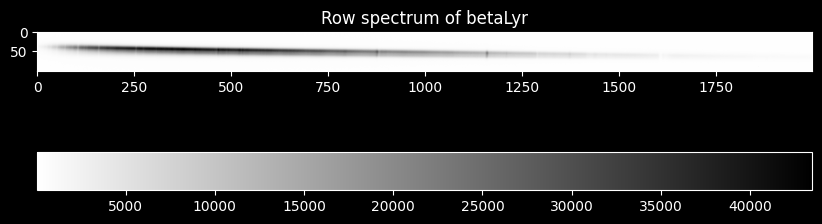

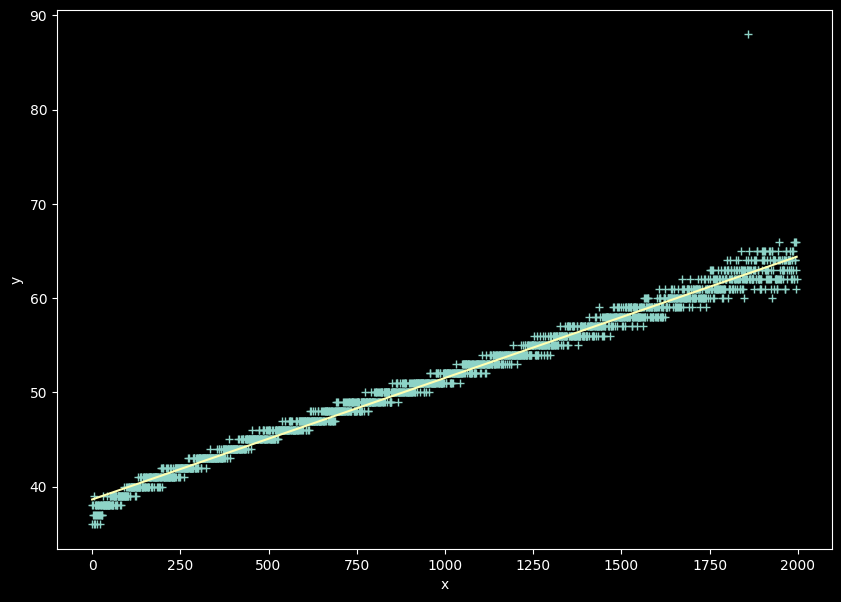

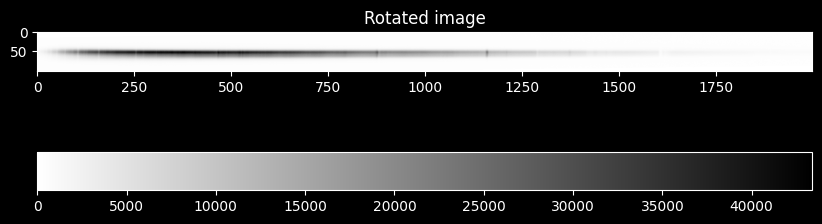

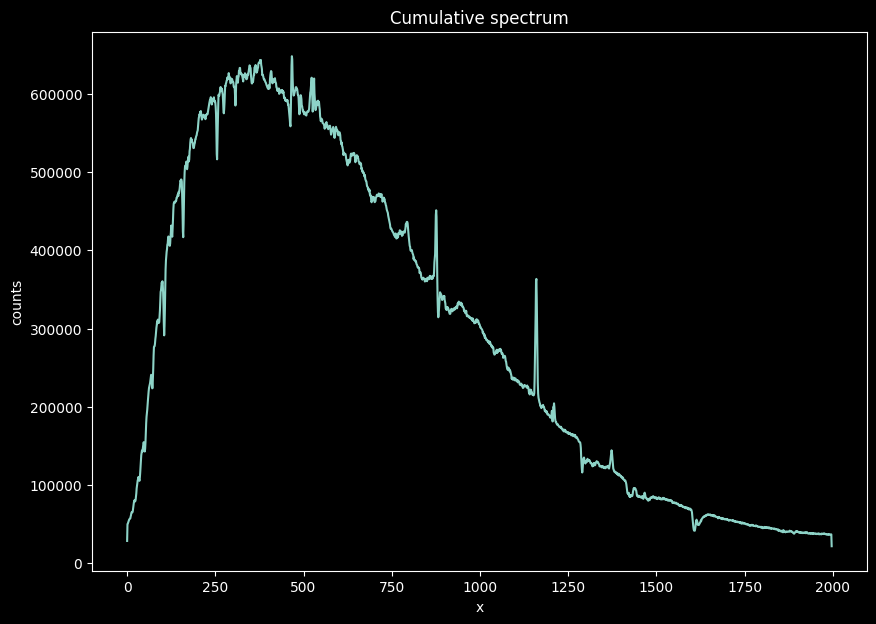

In [15]:
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from scipy.signal import correlate
import scipy.ndimage as ndimage

##!! 
def hotpx_remove(data):
    """`hotpx_remove(data)`

    Function to remove hot px from the images
    
    Taken by [*astropy documentation*](https://docs.astropy.org/en/stable/convolution/index.html)

    ## Parameters

    `data`: array_like
      image matrix
    
    ## Return

    The image matrix without hot pixels

    """
    kernel = Gaussian2DKernel(x_stddev=1)
    return interpolate_replace_nans(data, kernel)
##!!

##* 
def get_data_fit(path: str, lims: list = [0,-1,0,-1], hotpx: bool = False, v: int = -1, title: str = '', n: int = None, dim: list[int] = [10,7]) -> tuple:
    """Function to open fits file and extract data.
    It brings the path and extracts the data, giving a row image.
    You can set a portion of image and also the correction for hotpx.

    It calls the functions `hotpx_remove` and `showfits`.

    :param path: path of the fits file
    :type path: str
    :param lims: edges of the fits, defaults to [0,-1,0,-1]
    :type lims: list, optional
    :param hotpx: parameter to remove or not the hot pixels, defaults to False
    :type hotpx: bool, optional
    :param v: cmap parameter: 1 for false colors, 0 for grayscale, -1 for reversed grayscale; defaults to -1
    :type v: int, optional
    :param title: title of the image, defaults to ''
    :type title: str, optional
    :param n: figure number, defaults to None
    :type n: int, optional
    :param dim: figure size, defaults to [10,7]
    :type dim: list[int], optional

    :return: `hdul` list of the chosen fits file and `data` of the spectrum
    :rtype: tuple

    .. note:: `lims` parameter controls the x and y extremes in such the form [lower y, higher y, lower x, higher x]
    """
    # open the file
    hdul = fits.open(path)
    # print fits info
    hdul.info()

    # data extraction
    # format -> data[Y,X]
    data = hdul[0].data
    ly,ry,lx,rx = lims
    data = data[ly:ry,lx:rx]
    # hot px correction
    if hotpx == True:
        data = hotpx_remove(data)
    # Spectrum image
    showfits(data, v=v,title=title,n=n,dim=dim) 
    return hdul,data
##*

##*
def angle_correction(data: np.ndarray, init: list[float] = [0.9, 0.], angle: float | None = None) -> tuple[float, np.ndarray]:
    """Function to correct the inclination, rotating the image.
    It takes the maximum of each column and does a fit to find 
    the angle with the horizontal. The the image is rotated.

    :param data: image matrix
    :type data: np.ndarray
    :param init: initial values for the fit, defaults to [0.9,0.]
    :type init: list[float], optional

    :return: inclination angle and the corrected data
    :rtype: tuple[float, np.ndarray]
    """
    if angle == None:
        y_pos = np.argmax(data, axis=0)
        x_pos = np.arange(len(y_pos))
        def fitlin(x,m,q):
            return x*m+q
        initial_values = init
        for i in range(3):
            pop, pcov = curve_fit(fitlin,x_pos,y_pos,initial_values)
            m, q = pop
            Dm, Dq = np.sqrt(pcov.diagonal())
            if m == initial_values[0] and q == initial_values[1]: break
            initial_values = pop

        angle = np.arctan(m)*180/np.pi   # degrees
        Dangle = 180/np.pi * Dm/(1+m**2)
        print(f'\n- Fit results -\nm =\t{m} +- {Dm}\nq =\t{q} +- {Dq}\ncor =\t{pcov[0,1]/Dm/Dq}\nangle =\t{angle} +- ({Dangle/angle*100:.2f} %) deg')
        fastplot(x_pos,y_pos,2,'+')
        fastplot(x_pos,fitlin(x_pos,m,q),2,'-',labels=['x','y'])

    data_rot  = ndimage.rotate(data, angle, reshape=False)
    return angle, data_rot
##*


hdul, sp_data = get_data_fit(obj_fit, lims=lims_fit, title='Row spectrum of '+sel_obj, n=1)

# correcting for inclination angle
angle, sp_data = angle_correction(sp_data)

showfits(sp_data, title='Rotated image')

plt.show()

# taking the cumulative and plot the spectrum
spectrum = sp_data.sum(axis=0)

fastplot(np.arange(len(spectrum)), spectrum, title='Cumulative spectrum', labels=['x','counts'])

plt.show()


#### I.3.3 Flat correction

For the first night the flat was acquired during the observation of _Jupiter_.

['giove_alpy_26072022_0116', 'giove_lamp_alpy_26072022', 'giove_flat_alpy_26072022']
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_alpy_26072022_0116.fit
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_lamp_alpy_26072022.fit
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_flat_alpy_26072022.fit
Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_alpy_26072022_0116.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   

- Fit results -
m =	0.021152005659570476 +- 0.0004863875717431415
q =	86.0693937113861 +- 0.5108744950841753
cor =	-0.8659064033583633
angle =	1.2117399603003622 +- (2.30 %) deg


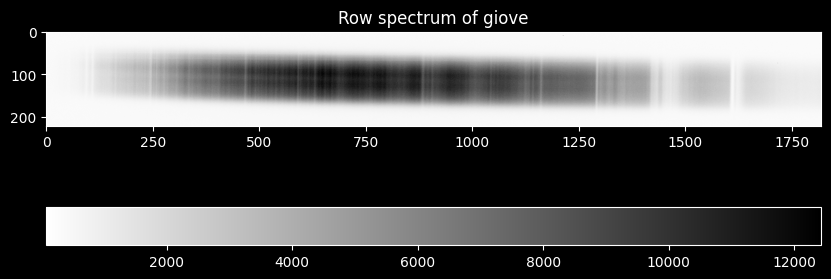

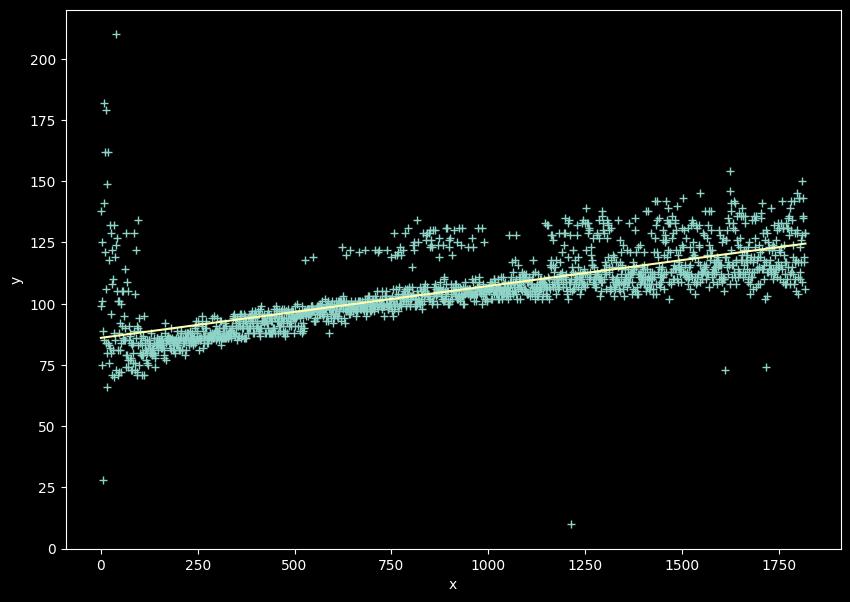

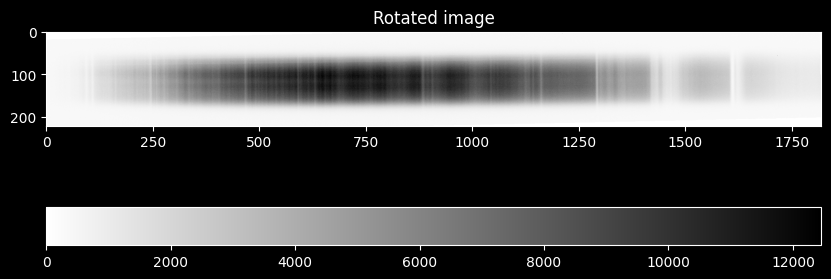

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_flat_alpy_26072022.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   


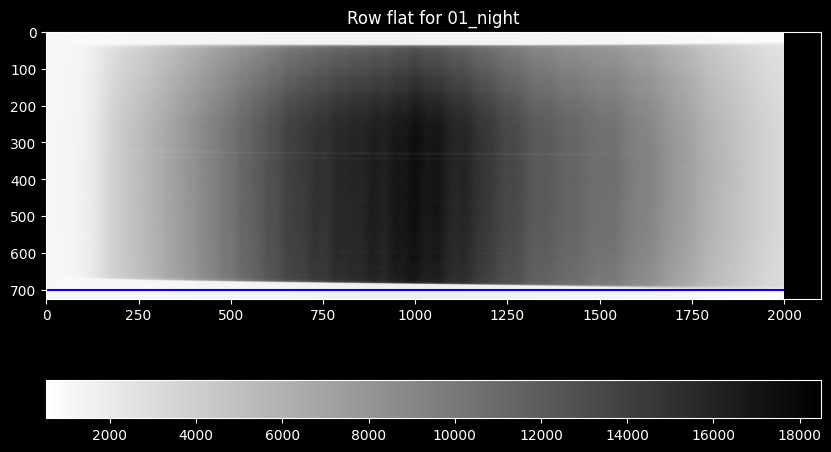

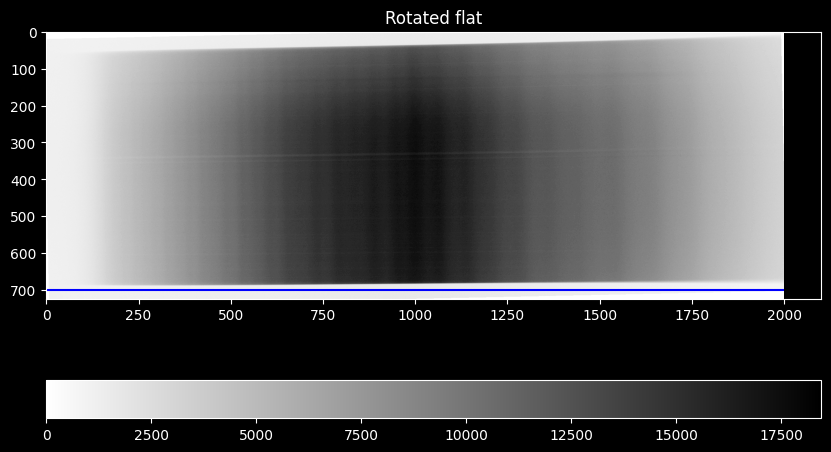

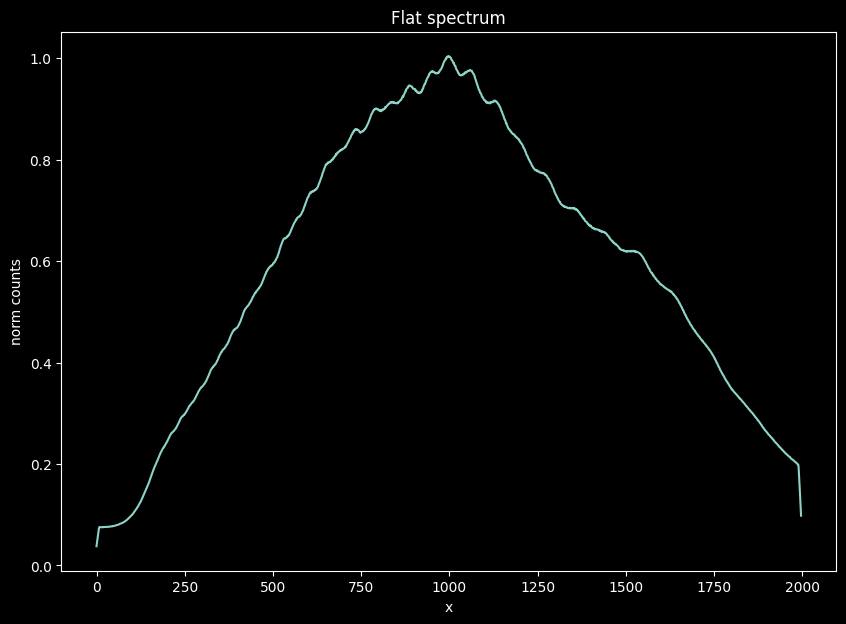

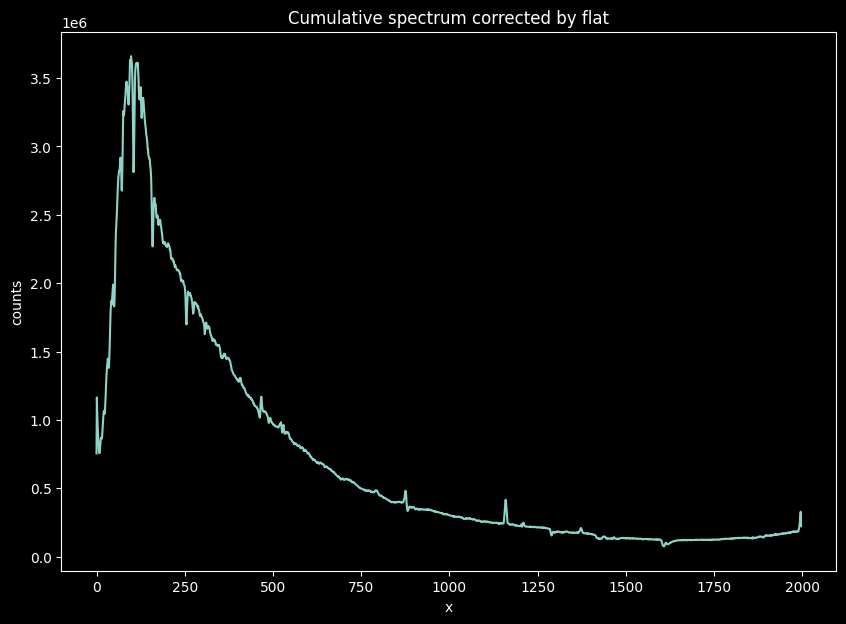

In [16]:
# target for flat of that night
f_sel_obj = 'giove'
# collecting data fits for that object
f_obj, f_lims = collect_fits(sel_obs, f_sel_obj)
print(f_obj)

f_obj_fit, f_obj_lamp, f_obj_flat = f_obj 
f_lims_fit, f_lims_lamp, f_lims_flat = f_lims

# appending the path
f_obj_fit = data_file_path(sel_obs, f_sel_obj, f_obj_fit)
f_obj_lamp = data_file_path(sel_obs, f_sel_obj, f_obj_lamp)
f_obj_flat = data_file_path(sel_obs, f_sel_obj, f_obj_flat)

print(f_obj_fit)
print(f_obj_lamp)
print(f_obj_flat)


f_hdul, f_sp_data = get_data_fit(f_obj_fit, lims=f_lims_fit, title='Row spectrum of '+f_sel_obj, n=1)

# correcting for inclination angle
f_angle, f_sp_data = angle_correction(f_sp_data)

showfits(f_sp_data, title='Rotated image')

plt.show()

# opening flat file
f_hdul_flat, f_sp_flat = get_data_fit(f_obj_flat, lims=f_lims_flat, title='Row flat for '+NIGHTS[sel_obs],n=1)
plt.hlines(699,0,2000, color='blue')

# correcting inclination
#!! Understand the inclination of the flat
_ , f_sp_flat = angle_correction(f_sp_flat,angle=f_angle)

showfits(f_sp_flat, title='Rotated flat')
plt.hlines(699,0,2000, color='blue')
plt.show()

# flat normalization
# find maximum
_, x_max = np.unravel_index(np.argmax(f_sp_flat), f_sp_flat.shape)
# cumulative value
tot_flat = f_sp_flat[:,x_max].sum()
# computing the normalized flat depending on position x
flat_value = f_sp_flat.sum(axis=0)/tot_flat

fastplot(np.arange(len(flat_value)), flat_value, title='Flat spectrum', labels=['x','norm counts'], numfig=1)

# correcting data by flat
if f_lims_flat[2] == lims_fit[2]:
    flt_spectrum = spectrum / flat_value[:len(spectrum)]
    fastplot(np.arange(len(flt_spectrum)), flt_spectrum, title='Cumulative spectrum corrected by flat', labels=['x','counts'],numfig=2)
else:
    flt_spectrum = spectrum
plt.show()

#### <a id='toc1_1_2_'></a>[I.3.4 Calibration](#toc0_)

Take one object arbitrally and using the lines of the lamp NeAr in `calibration_lines.txt` fit the transmission function that converts px to lambda.


Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_lamp_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   


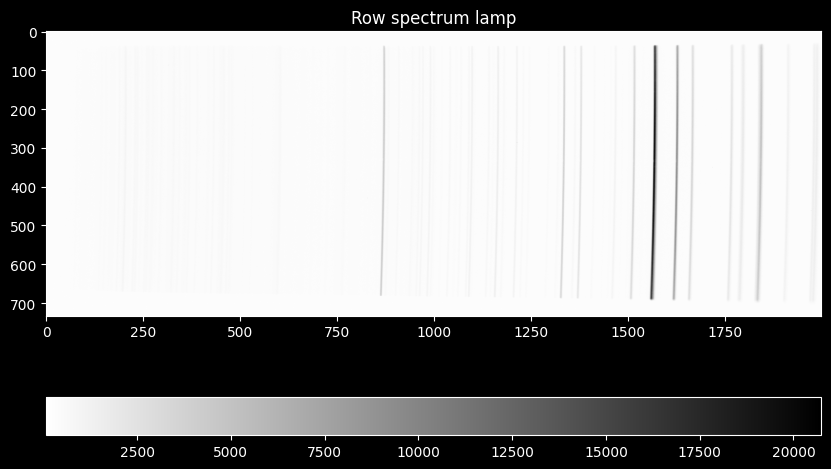

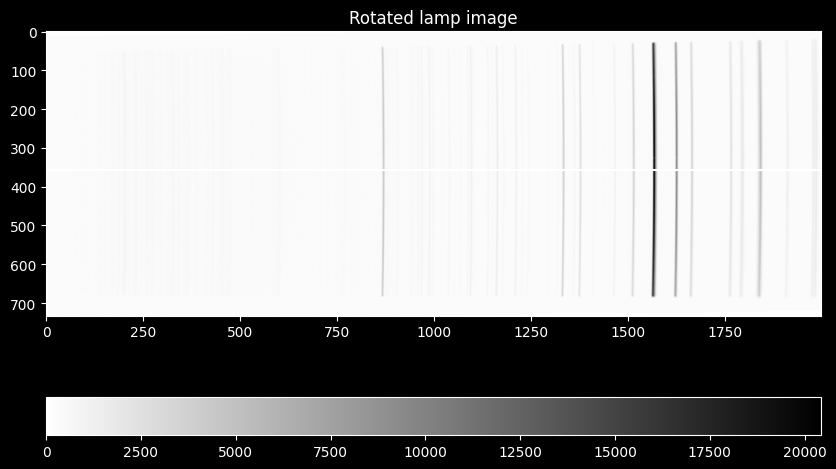

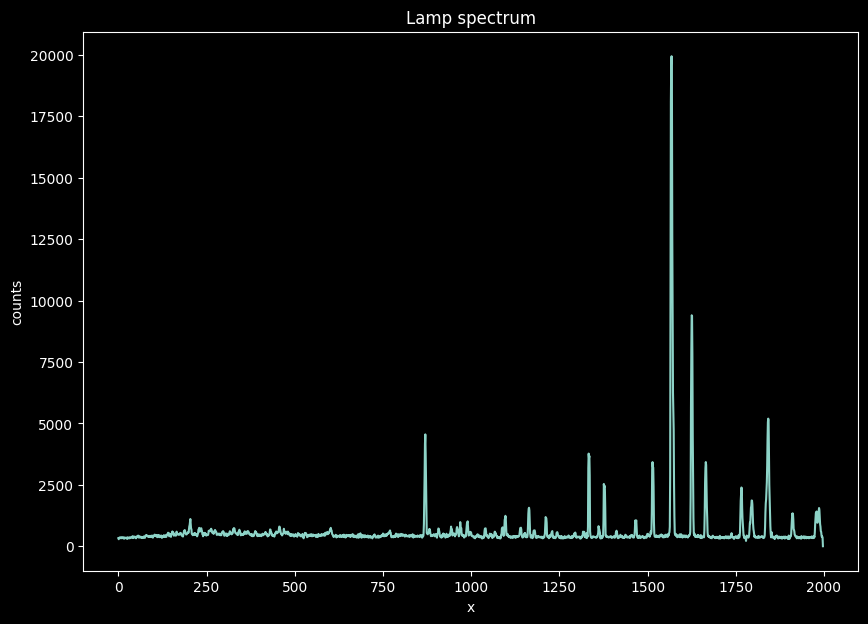

Fit results for 2 params
p0 =	3805.1786370893956 +- 19.518721326546768
p1 =	2.3558282048942205 +- 0.01358085113394155
cor =	-96.46303371943901 %


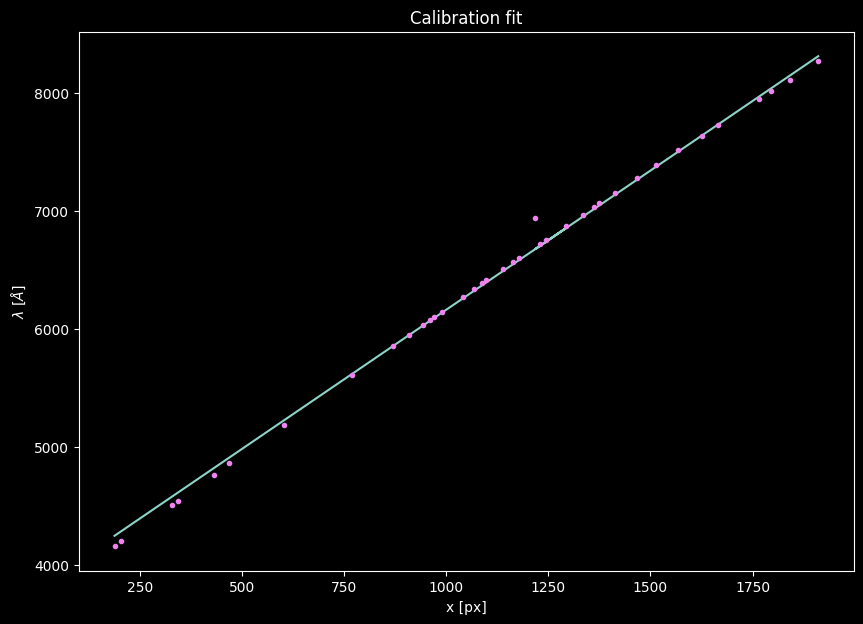

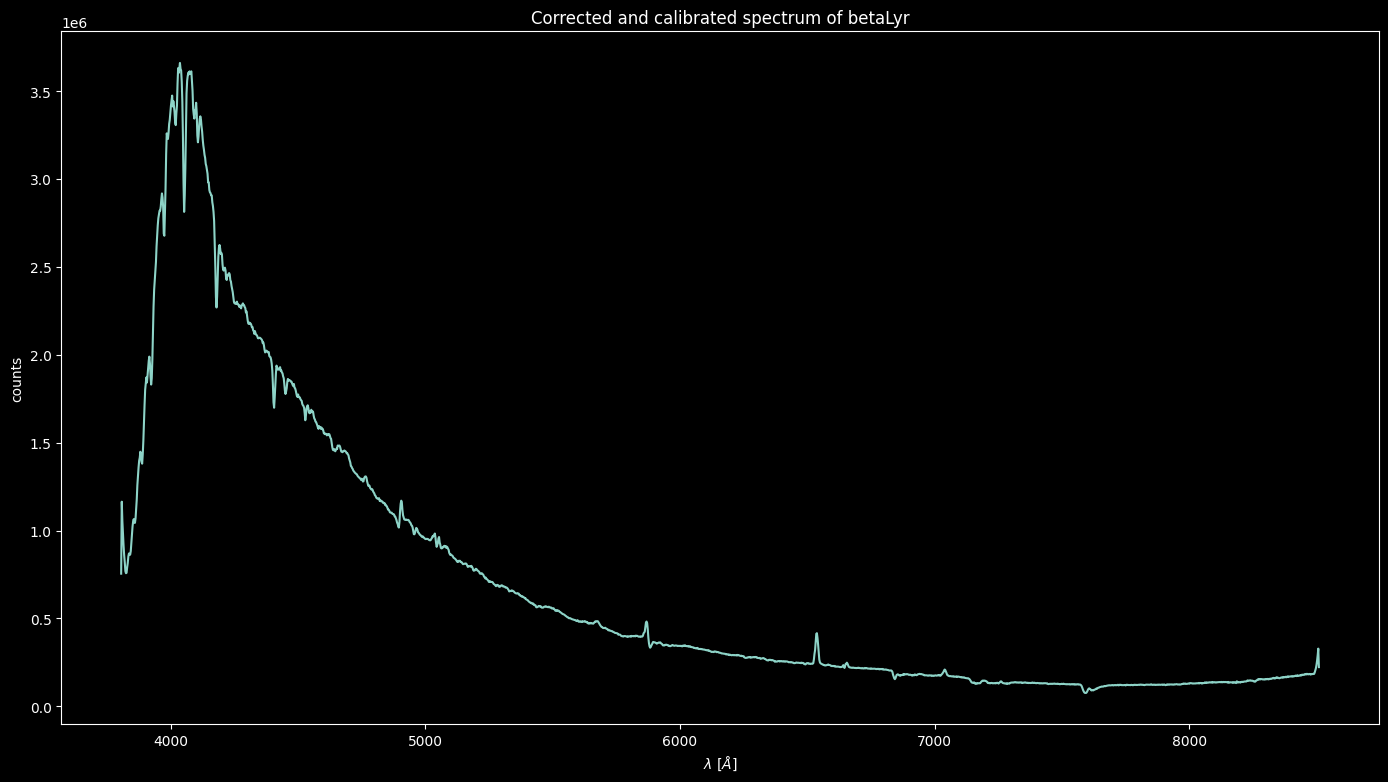

In [31]:
hdul_lamp, sp_lamp = get_data_fit(obj_lamp,lims=lims_lamp, title='Row spectrum lamp',n=1)

_, sp_lamp = angle_correction(sp_lamp, angle=angle)

showfits(sp_lamp, title='Rotated lamp image')

sel_high = int((685.7+26.8) / 2)

plt.hlines(sel_high,0,len(sp_lamp[0])-1)

plt.show()

spectrum_lamp = sp_lamp[sel_high]
fastplot(np.arange(len(spectrum_lamp)), spectrum_lamp, title='Lamp spectrum',labels=['x','counts'])

plt.show()

# calibration file
cal_file = os.path.join(os.path.split(obj_fit)[0],'calibration_lines.txt')
# extraction
lines, x, Dx = np.loadtxt(cal_file, unpack=True)
# fit
def fit_func(x,p0,p1):
    return p0 + p1*x

initial_values = [3600,2.6]
pop, pcov = curve_fit(fit_func,x,lines,initial_values)
for i in range(2):
    initial_values = pop
    Dy = Dx*pop[1]
    pop, pcov = curve_fit(fit_func,x,lines,initial_values, sigma=Dy)
p0,p1 = pop
Dp0,Dp1 = np.sqrt(pcov.diagonal())

print(f'Fit results for 2 params\np0 =\t{p0} +- {Dp0}\np1 =\t{p1} +- {Dp1}\ncor =\t{pcov[0][1]/Dp0/Dp1*100} %')

trasf_func = lambda x : fit_func(x,p0,p1)

plt.figure(figsize=[10,7])
plt.title('Calibration fit')
plt.errorbar(x,lines,xerr=Dx,fmt='.',color='violet')
plt.plot(x,trasf_func(x))
plt.xlabel('x [px]')
plt.ylabel('$\lambda$ [$\AA$]')

plt.show()

lengths = trasf_func(np.arange(len(flt_spectrum)))

fastplot(lengths,flt_spectrum,title='Corrected and calibrated spectrum of '+sel_obj,labels=['$\lambda$ [$\AA$]','counts'],dim=[17,9])

plt.show()

In [18]:
obj_ind = 0

target_file = names[obj_ind][0]
calibration_file = names[obj_ind][1]
fold = fold0 + os.path.join(folders[obj_ind],'')

# lambda function to open fits
path = lambda name : fold + name + '.fit'

# Set the cut
ly,ry = [650,1400]
lx,rx = [760,-1]

## Open target image
# data[Y,X]
hdul, data = get_data_fit(path(target_file),lims=[ly,ry,lx,rx],hotpx=True)
nx = len(data[0,:]); ny = len(data[:,0])

hdul[0].header['OBJECT'] = 'Beta Lyr'
hdul.info()

print(nx)


# Spectrum image
showfits(data,folders[obj_ind])



# rotation correction
# rotate the image
angle, data_rot = angle_correction(data)

# plot
plt.figure(figsize=[13,10])
plt.title(folders[obj_ind]+' - rotated')
plt.imshow(data_rot, cmap='gray_r')
plt.hlines(532,0,1500)
plt.colorbar()

# spectrum graph
data = data_rot
cut = 563
values = data[cut,:]
nx = len(data[0,:]); ny = len(data[:,0])
print(nx)

# remove noise
# values -= data[350,:]

# plot at cut
fastplot(np.linspace(0,nx,nx),values,title=f'Object spectrum at {cut}')


# sum in a range of the spectrum
values = np.array([data[555:574,j].sum() for j in range(nx) ])

# remove noise
# values -= data[350,:]

# plot
fastplot(np.linspace(0,nx,nx),values,title='Object spectrum')

plt.show()


hdul.close()

NameError: name 'names' is not defined

#### <a id='toc1_1_2_2_'></a>[Calibrate the lamp](#toc0_)

Make a fit for the lines with a polynom of 3rd order and plot the spectrum of the obj in lambda.

Then make a table with the lines.

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/betaLyr/betaLyr_alpy_lamp_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
1988 1988


/tmp/ipykernel_7598/944886609.py:59: RuntimeWarning: invalid value encountered in sqrt
  error = np.array([np.sqrt((pcov[i,:]).sum()) for i in range(4)])


[ 3.68454323e+03  2.54216802e+00 -1.14929184e-05 -3.29918443e-08] [11.53302683         nan  0.01944174         nan]


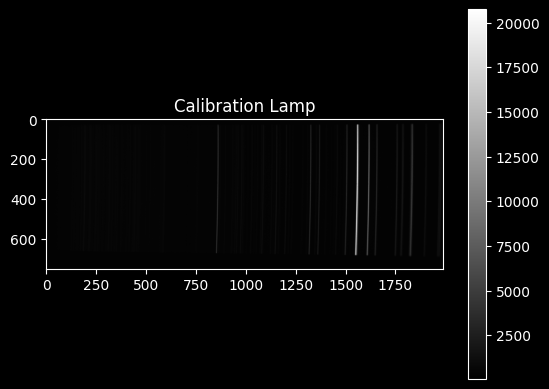

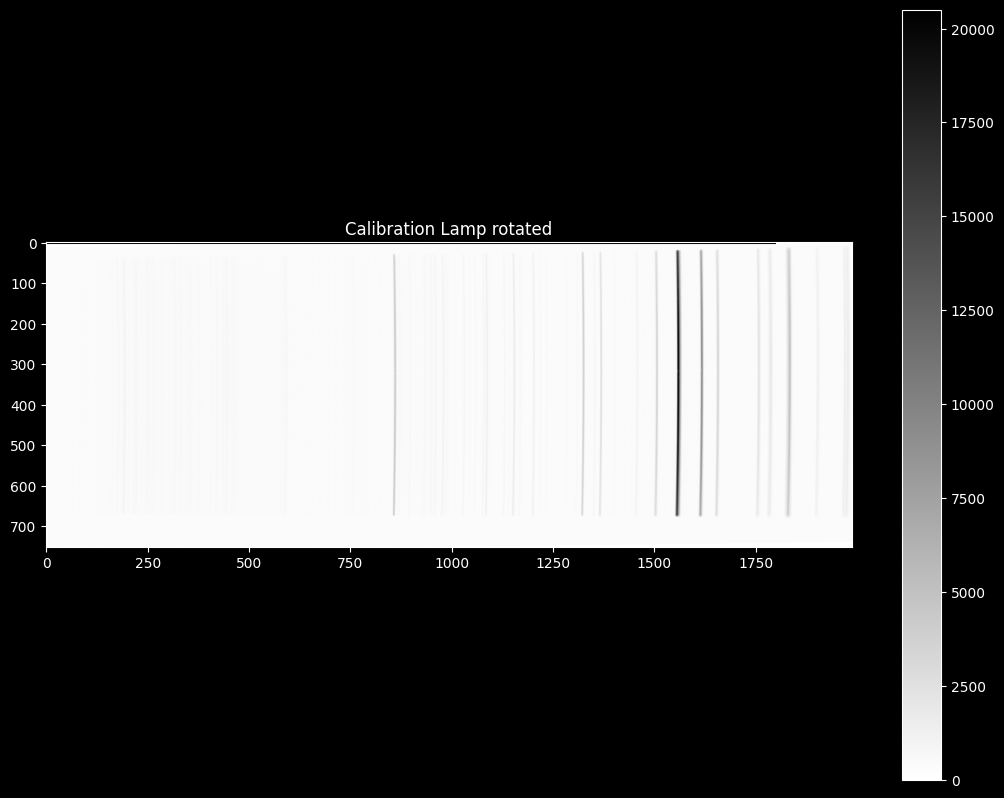

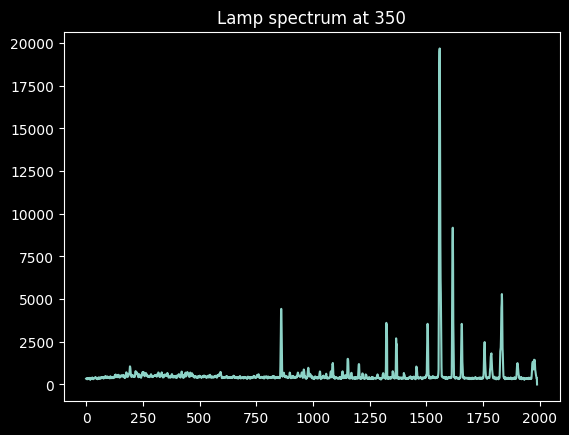

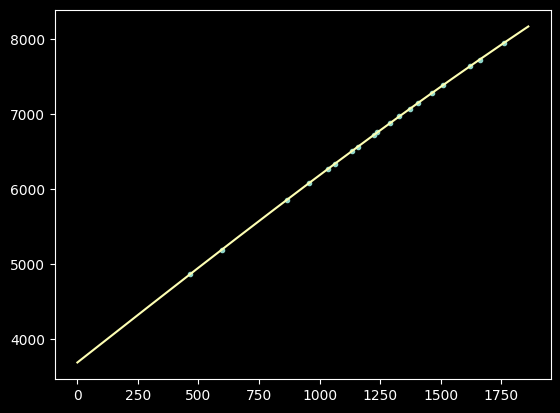

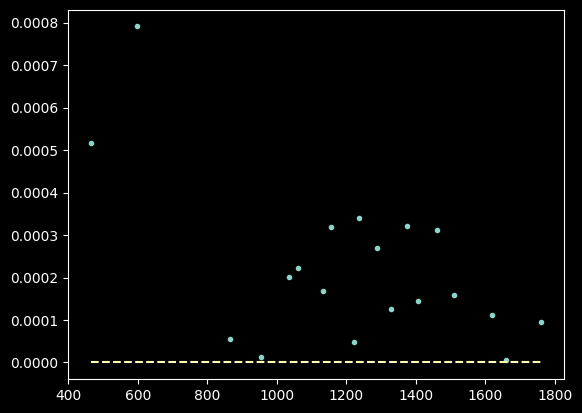

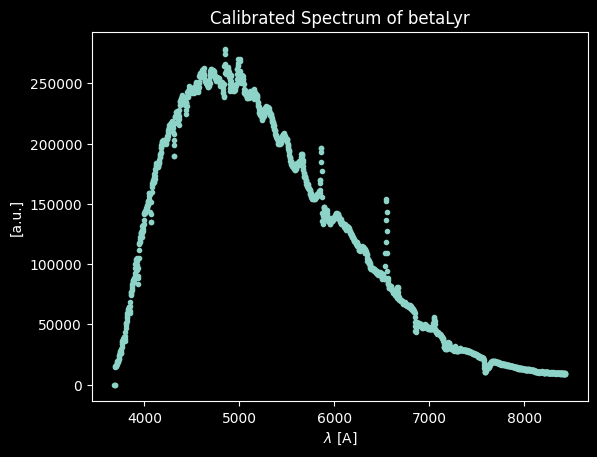

20.919330459909997
dist = 48.32112118924124


/tmp/ipykernel_7598/944886609.py:100: RuntimeWarning: divide by zero encountered in scalar divide
  mag_dist = np.log10(np.array([red_val[i+1]/red_val[i] for i in range(len(red_val)-1)]))


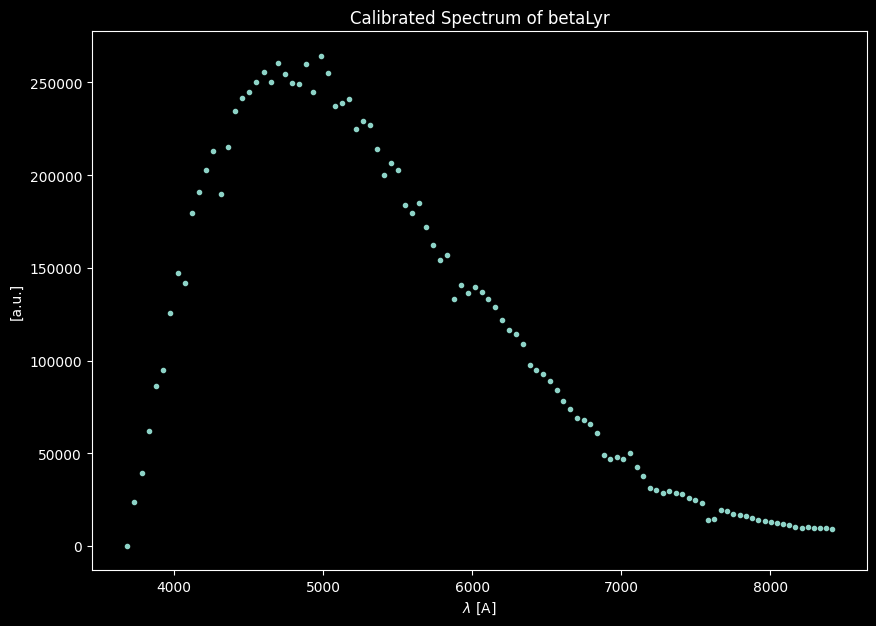

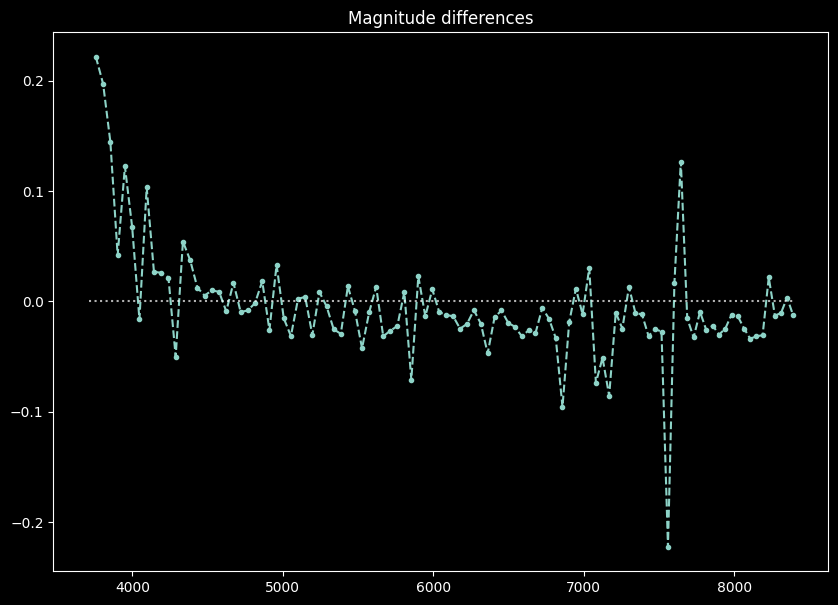

In [ ]:
# Open calibraion file
hdul = fits.open(path(calibration_file))

hdul.info()

# data[Y,X]
cdata = hdul[0].data
cdata = cdata[ly:ry,lx:rx]
cnx = len(cdata[0,:]); cny = len(cdata[:,0])

print(nx,cnx)
cdata_rot = ndimage.rotate(cdata, angle, reshape=False)


# Spectrum image
plt.figure()
plt.title('Calibration Lamp')
plt.imshow(cdata, cmap='gray')
plt.colorbar()

plt.figure(figsize=[13,10])
plt.title('Calibration Lamp rotated')
plt.imshow(cdata_rot, cmap='gray_r')
plt.hlines(0,0,1800, 'black')
plt.colorbar()


# spectrum graph
cdata = cdata_rot
cut = 350
cvalues = cdata[cut,:]
cnx = len(cdata[0,:]); cny = len(cdata[:,0])


plt.figure()
plt.title(f'Lamp spectrum at {cut}')
plt.plot(np.linspace(0,cnx,cnx),cvalues)



## Fit
lA, lpx = np.loadtxt(fold+'calibration_lines.txt',unpack=True)

def FitFun(x,p0,p1,p2,p3):
    return p0 + p1*x + p2*x**2 + p3*x**3

initial_values = np.array([1e2,1e1,1.,0.])
pop, pcov = curve_fit(FitFun,lpx,lA,initial_values)
p1,p2,p3,p4 = pop
Dp1,Dp2,Dp3,Dp4 = np.sqrt(pcov.diagonal())

for i in range(2):
    initial_values = pop
    pop, pcov = curve_fit(FitFun,lpx,lA,initial_values)
    p1,p2,p3,p4 = pop
    Dp1,Dp2,Dp3,Dp4 = np.sqrt(pcov.diagonal())


error = np.array([np.sqrt((pcov[i,:]).sum()) for i in range(4)])
print(pop,error)

plt.figure()
xx = np.linspace(0,max(lpx)+100,1000)
plt.plot(lpx,lA,'.')
plt.plot(xx,FitFun(xx,p1,p2,p3,p4))

plt.figure()
plt.plot(lpx,abs(1-FitFun(lpx,p1,p2,p3,p4)/lA),'.')
plt.plot([min(lpx),max(lpx)],[0,0],'--')

##! True target spectrum
px = np.linspace(0,nx,nx)
l = FitFun(px,p1,p2,p3,p4)

plt.figure()
plt.title('Calibrated Spectrum of ' + folders[obj_ind])
plt.xlabel('$\lambda$ [A]'); plt.ylabel('[a.u.]')
plt.plot(l,values,'.')

plt.show()



hdul.close()


#### <a id='toc1_1_2_3_'></a>[Flat](#toc0_)

Open the flat and Jupiter files, adjust rotation and take the normalized flat.

Then plot the corrected spectrum.

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/giove/giove_flat_alpy_26072022.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/giove/giove_alpy_26072022_0116.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
1988
1988
0.6810687149950692 1.2444388492436464
1988 1988 1988
20.919330459909997
1988 1988
dist = 48.32112118924124


/tmp/ipykernel_7598/2493242783.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  mag_dist = np.log10(np.array([red_val[i+1]/red_val[i] for i in range(len(red_val)-1)]))


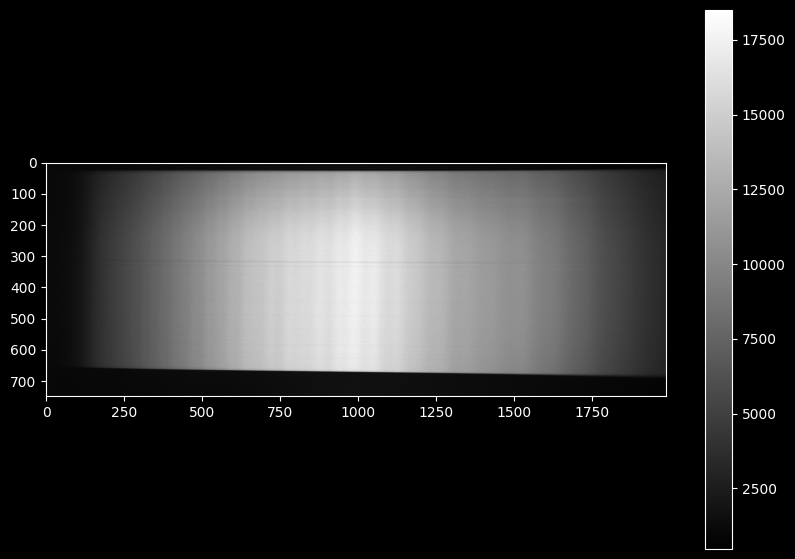

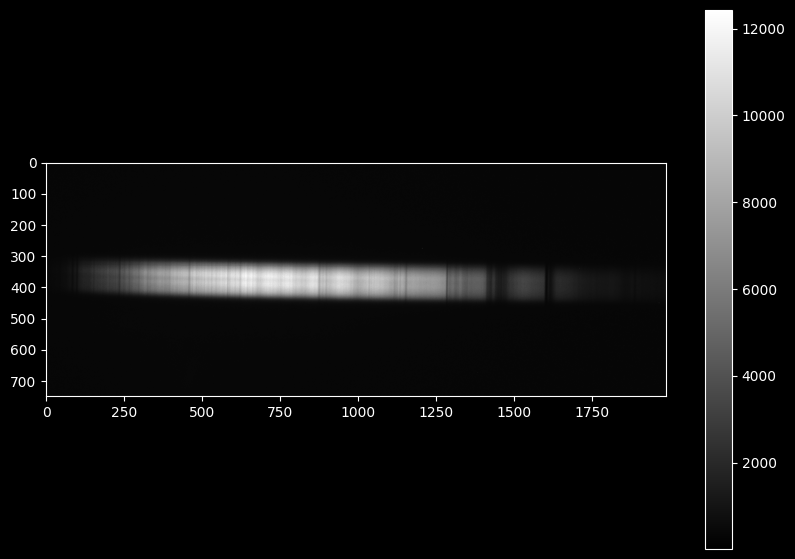

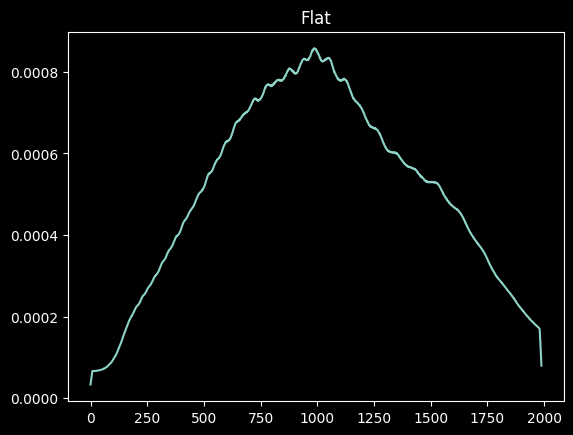

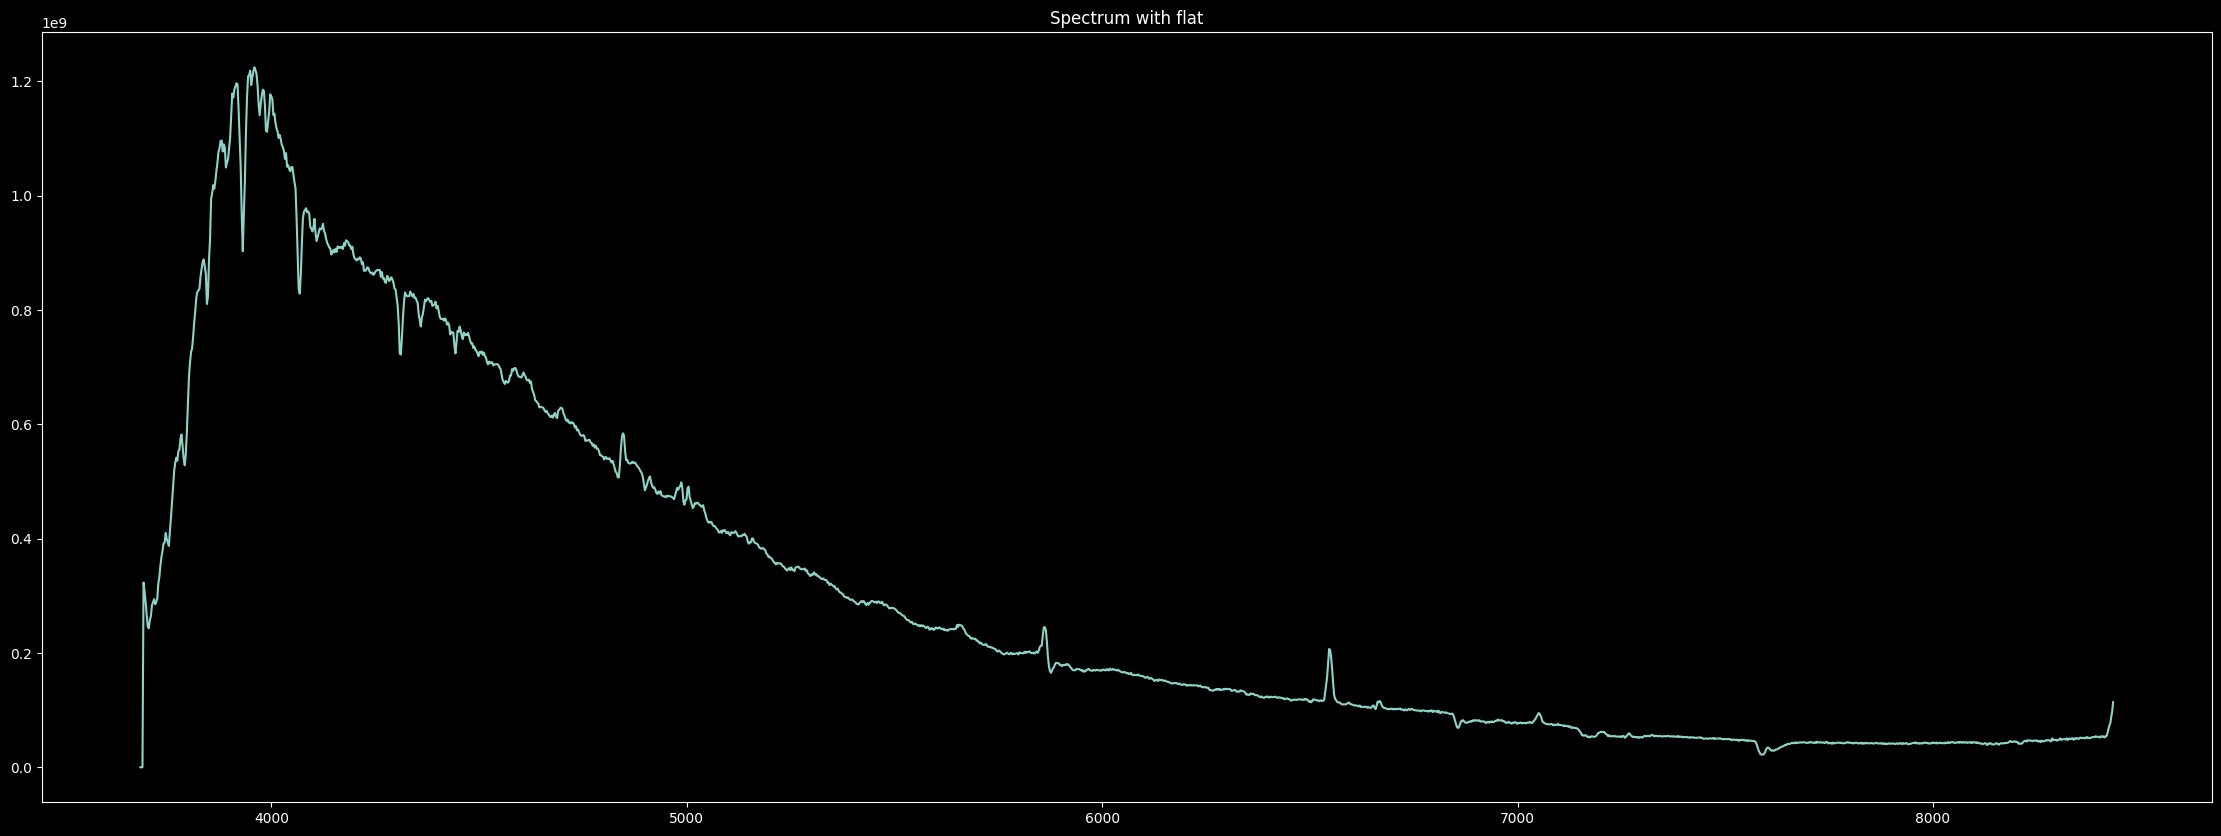

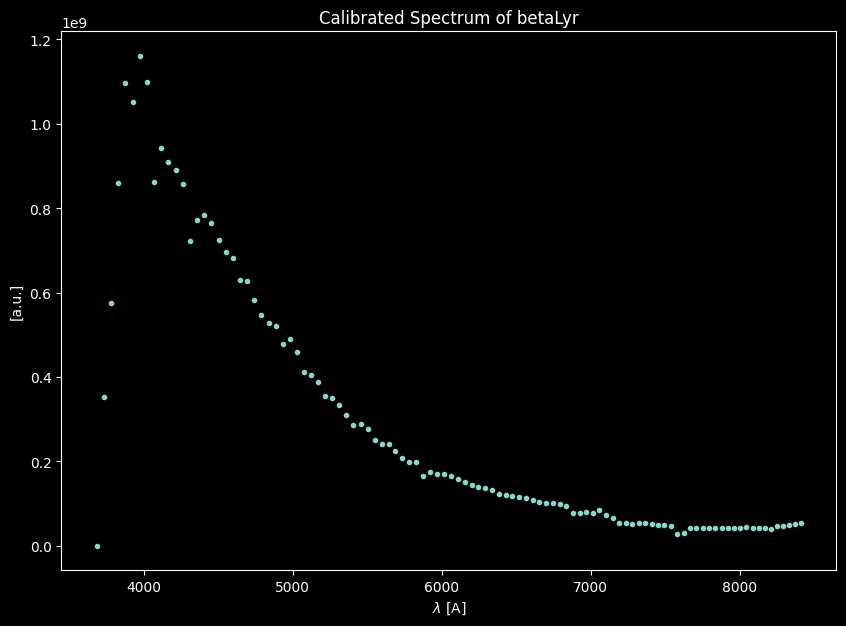

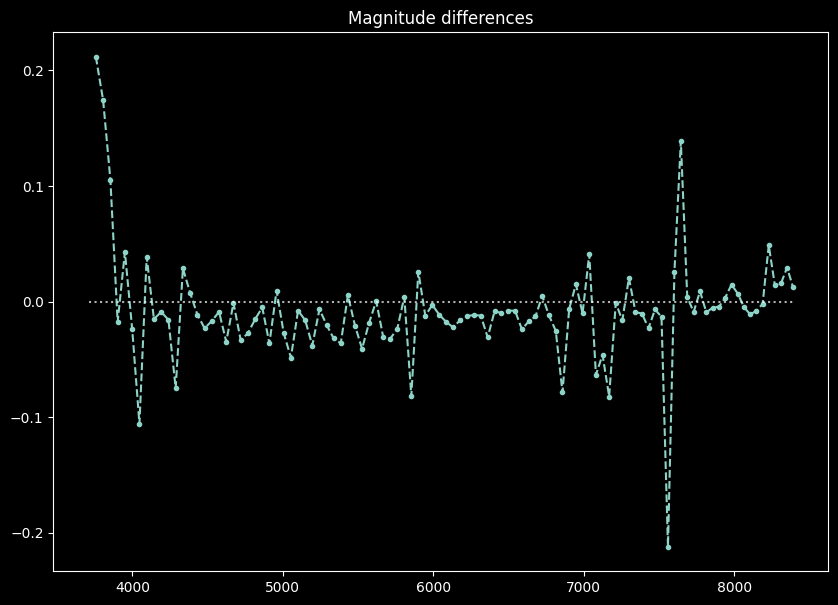

In [ ]:
hdulFlat, dataFlat = get_data_fit(fold0+'giove/'+names[2][2]+'.fit',lims=[ly,ry,lx,rx])
hdulJup, dataJup   = get_data_fit(fold0+'giove/'+names[2][0]+'.fit',lims=[ly,ry,lx,rx])

print(len(dataFlat[0,:]))
angleJup, dataJup = angle_correction(dataJup)
dataFlat = ndimage.rotate(dataFlat,angleJup,reshape=False)
print(len(dataFlat[0,:]))


nxf = len(dataFlat[0,:]); nyf = len(dataFlat[:,0])

print(angle,angleJup)
print(nx,cnx,nxf)



valuesFlat = np.array([dataFlat[:,j].sum() for j in range(nxf)])

flat = dataFlat.sum()

# Flat
flat = valuesFlat/flat

plt.figure()
plt.title('Flat')
plt.plot(np.linspace(0,nxf,nxf),flat)

plt.figure(figsize=[28,10])
plt.title('Spectrum with flat')
plt.plot(l,values/flat)

mean_dist = sum([l[i+1] - l[i] for i in range(len(l)-1)])/(len(l)-1)

print(50/mean_dist)

num_red = 19
num_int = 0

print(len(values),len(flat))

red_l = l[num_int::num_red]
red_val = (values/flat)[num_int::num_red]

plt.figure(figsize=[10,7])
plt.title('Calibrated Spectrum of ' + folders[obj_ind])
plt.xlabel('$\lambda$ [A]'); plt.ylabel('[a.u.]')
plt.plot(red_l,red_val,'.')

print(f'dist = {red_l[1] - red_l[0]}')

mag_dist = np.log10(np.array([red_val[i+1]/red_val[i] for i in range(len(red_val)-1)]))
mag_l = np.array([(red_l[i+1]+red_l[i])/2 for i in range(len(red_l)-1)])

plt.figure(figsize=[10,7])
plt.title('Magnitude differences')
plt.plot(mag_l,mag_dist,'.--')
plt.hlines(0,min(mag_l),max(mag_l),linestyles='dotted',alpha=0.7)

plt.show()


plt.show()

### <a id='toc1_1_3_'></a>[Correlation](#toc0_)

Now choose another target and maximize the convolution between the previous lamp spectrum and the this one to get the shift of the picks.

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/vega/vega_alby_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/vega/vega_alby_lamp_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
0.0010150129396375783


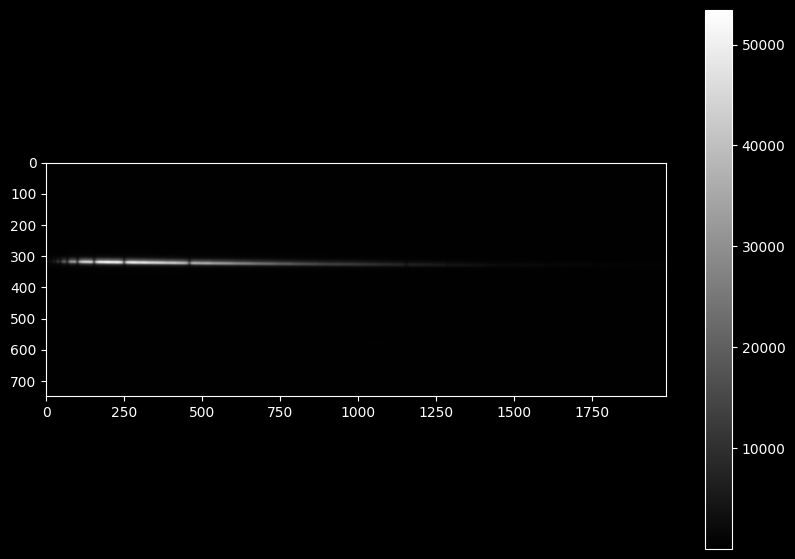

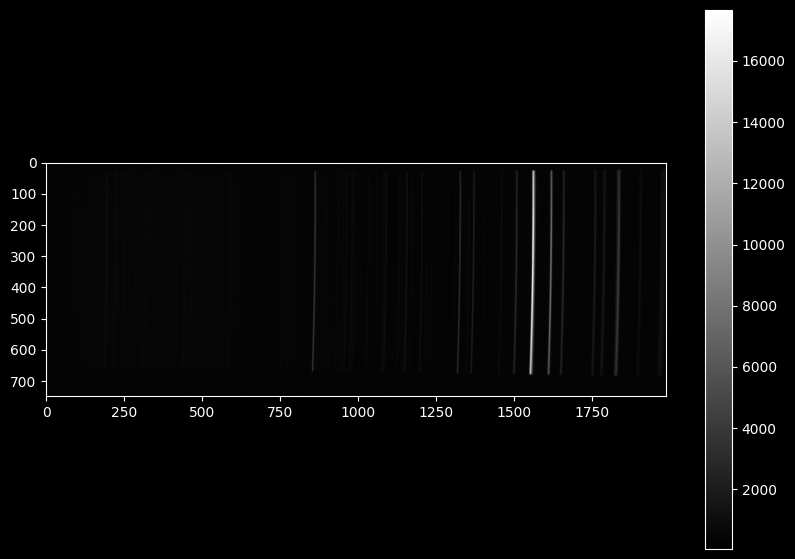

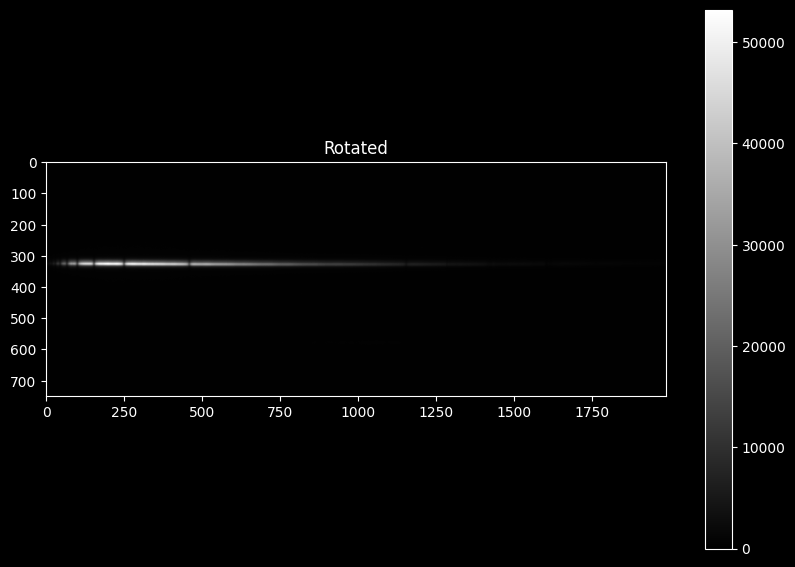

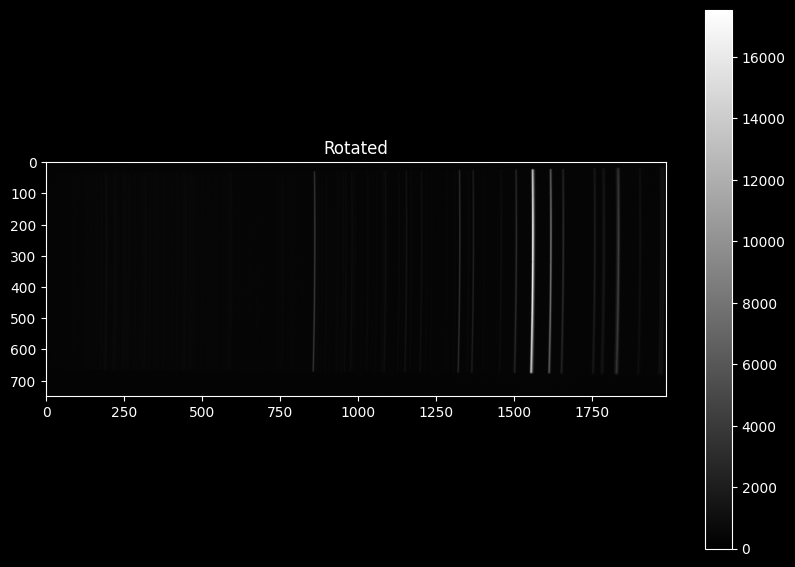

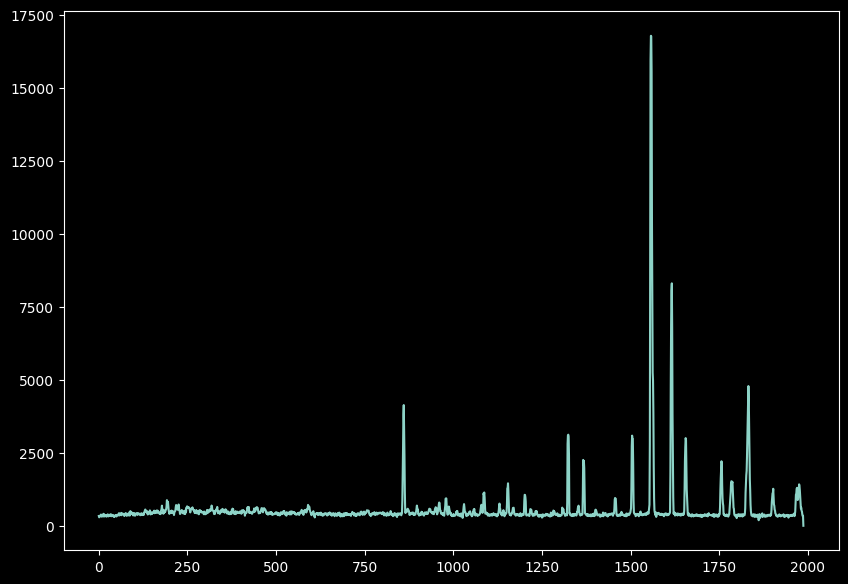

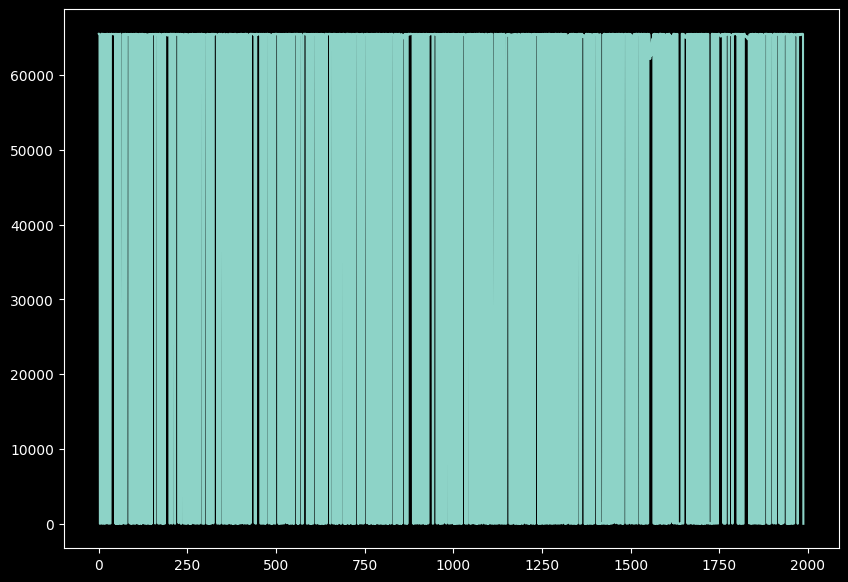

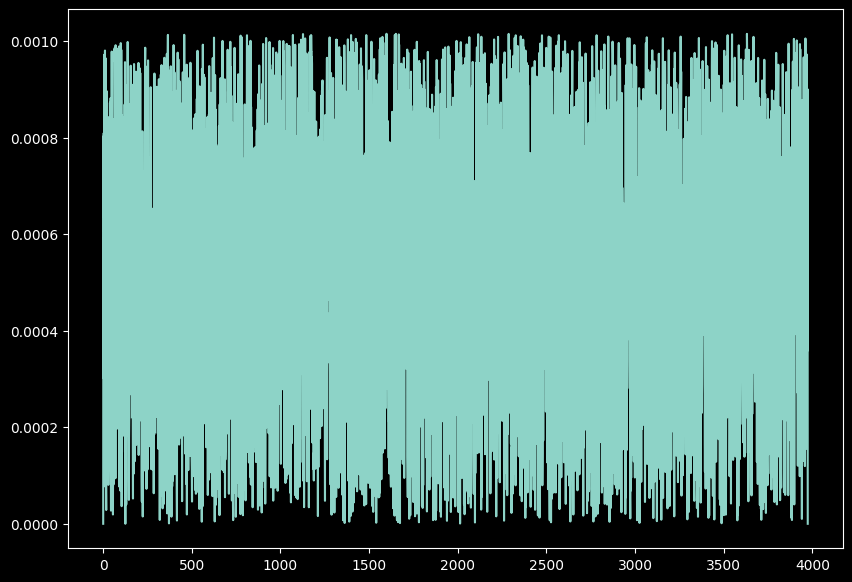

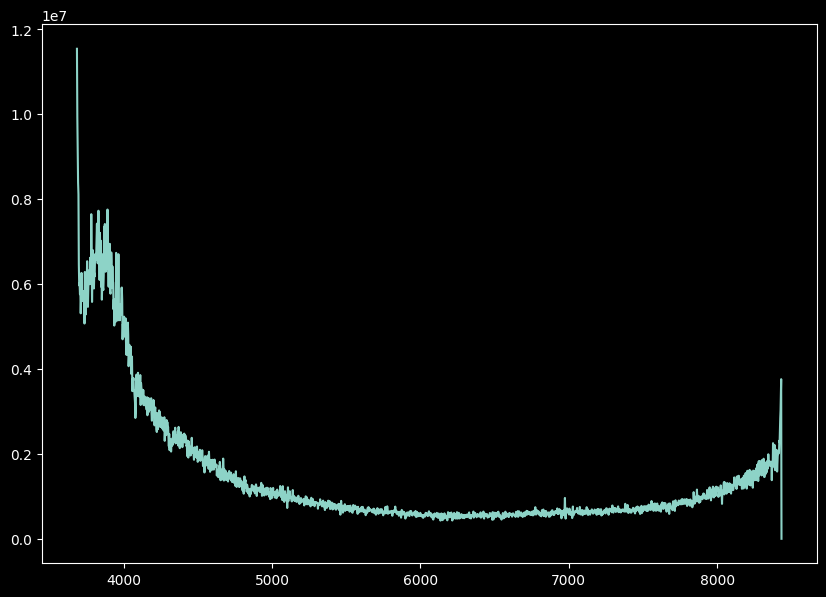

In [ ]:
from scipy.signal import correlate

obj_ind = 11

target_file = names[obj_ind][0]
calibration_file = names[obj_ind][1]
fold = fold0 + folders[obj_ind]+'/'

# function to open fits
path = lambda name : fold + name + '.fit'

hdul1,data1 = get_data_fit(path(target_file),lims=[ly,ry,lx,rx])
hdul2,data2 = get_data_fit(path(calibration_file),lims=[ly,ry,lx,rx])

print(type(data))

angle, data1 = angle_correction(data1)
data2 =  ndimage.rotate(data2, angle, reshape=False)

showfits(data1,title='Rotated')
showfits(data2,title='Rotated')


## Correlation
# set the fit lamp values as a standard
stdLamp = cvalues
stdnx   = len(stdLamp)

values2 = data2[cut,:]
nx2 = len(values2)

print(type(values2))

fastplot(range(nx2),values2)
fastplot(range(nx2),values2-stdLamp)


corr = correlate(stdLamp,values2)/np.sqrt((values2**2).sum()*(stdLamp**2).sum())#nx2
print(max(corr))
fastplot(range(len(corr)),corr)

corr = max(corr)
tmppos = lambda x : np.where(x == max(x))

x = np.linspace(0,nx2,nx2)
if( tmppos(values2)[0]-tmppos(stdLamp)[0]>0 ):
    x -= corr
else:
    x += corr

l2 = FitFun(x,p1,p2,p3,p4)

fastplot(l2,data1[cut,:]/flat)

plt.show()